In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/pruning

Mounted at /content/drive
/content/drive/MyDrive/pruning


In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_root_folder = './data/mnist/'
mnist_train = torchvision.datasets.FashionMNIST(
    mnist_root_folder, download = True,
    transform = transform
)

mnist_test = torchvision.datasets.FashionMNIST(
    mnist_root_folder, train = False, download = True,
    transform = transform
)
classes = mnist_train.classes

batch_size = 128

train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size,
    shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size,
    shuffle=True, num_workers=2
)

# Feed-forward net

## Training

In [3]:
from torch import nn

out_size = len(classes)
in_size = 28 * 28

dnn = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_size, 128),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(32, out_size)
).cuda()

In [21]:
from collections import defaultdict
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

def plot_learning_curves(history): 
    plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс')
    plt.plot(history['loss']['train'], label='train', lw=3)
    plt.plot(history['loss']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность')
    plt.plot(history['acc']['train'], label='train', lw=3)
    plt.plot(history['acc']['val'], label='val', lw=3)
    plt.xlabel('Эпоха')
    plt.legend()
    
    plt.show()

def train(
    model, 
    criterion,
    optimizer, 
    train_loader,
    val_loader,
    num_epochs=50
):
    history = defaultdict(lambda: defaultdict(list))
    train_size = len(train_loader) * train_loader.batch_size
    val_size = len(val_loader) * test_loader.batch_size

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        model.train(True) 
        back_time = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().cuda())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.detach().cpu()
            y_pred = logits.max(1)[1].detach().cpu()
            train_acc += (y_batch.cpu() == y_pred).sum().float()

        train_loss /= train_size
        train_acc /= train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.train(False) 

        for X_batch, y_batch in val_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().cuda())

            val_loss += loss.detach().cpu()
            y_pred = logits.max(1)[1].detach().cpu()
            val_acc += (y_batch.cpu() == y_pred).sum().float()

        val_loss /= val_size
        val_acc /= val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()
        print("Epoch {} of {}".format(
            epoch + 1, num_epochs))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 50 of 50
  training loss (in-iteration): 	0.008224
  validation loss (in-iteration): 	0.011279
  training accuracy: 			90.25 %
  validation accuracy: 			88.28 %


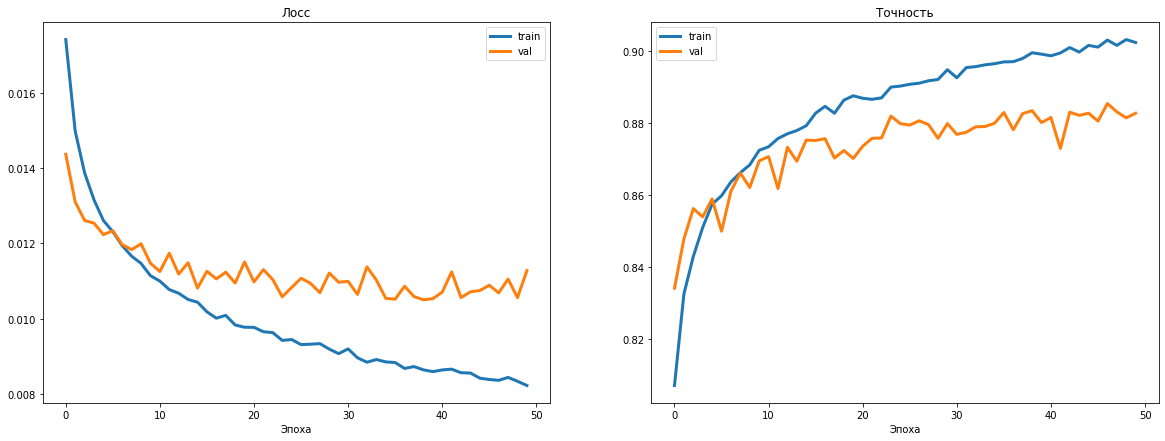

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn.parameters(), weight_decay = 0)
device = torch.device('cuda')

dnn, history = train(
    dnn, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50
)

In [ ]:
torch.save(dnn.state_dict(), 'models/mnist_dnn.pt')

In [4]:
dnn.load_state_dict(torch.load('models/mnist_dnn.pt'))
dnn.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=32, bias=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=10, bias=True)
)

## Pruning

#### Базовая версия алгоритма

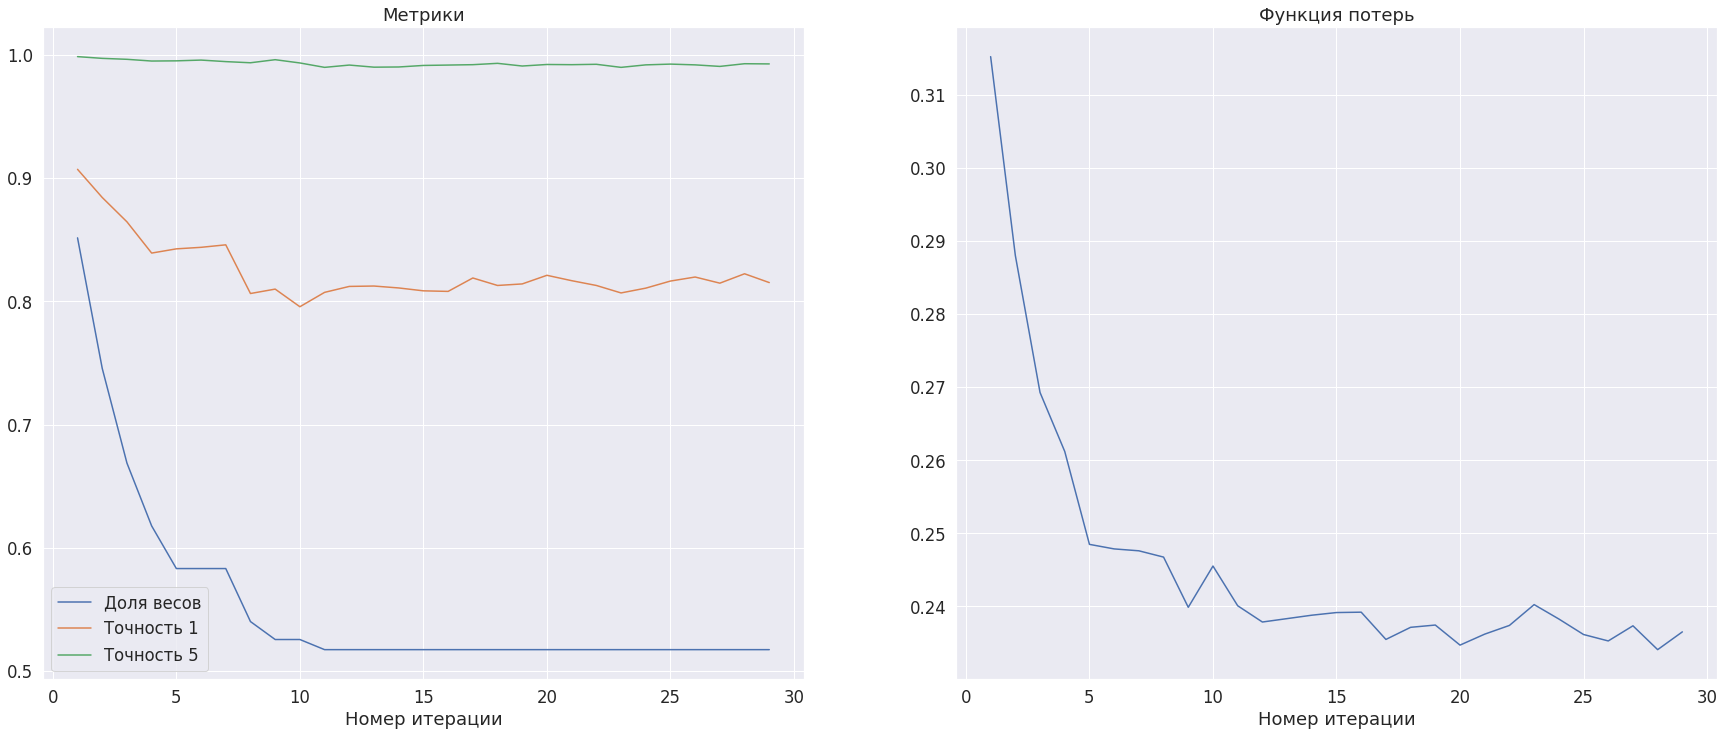

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = ModelPruningEncoder(dnn)
mutator = RandomMutator(mutation_prob = 0.15)

l1, l2, l3 = 1, 1, 1
def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    top1_errors = 1 - model_acc1
    top5_errors = 1 - model_acc5
    return (l1*weight_ratio + l2*top1_errors + l3*top5_errors) / (l1 + l2 + l3)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, train_loader, max_iter = 200)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

dnn_pruned1 = mtl.prune()

#### OneWayMutator

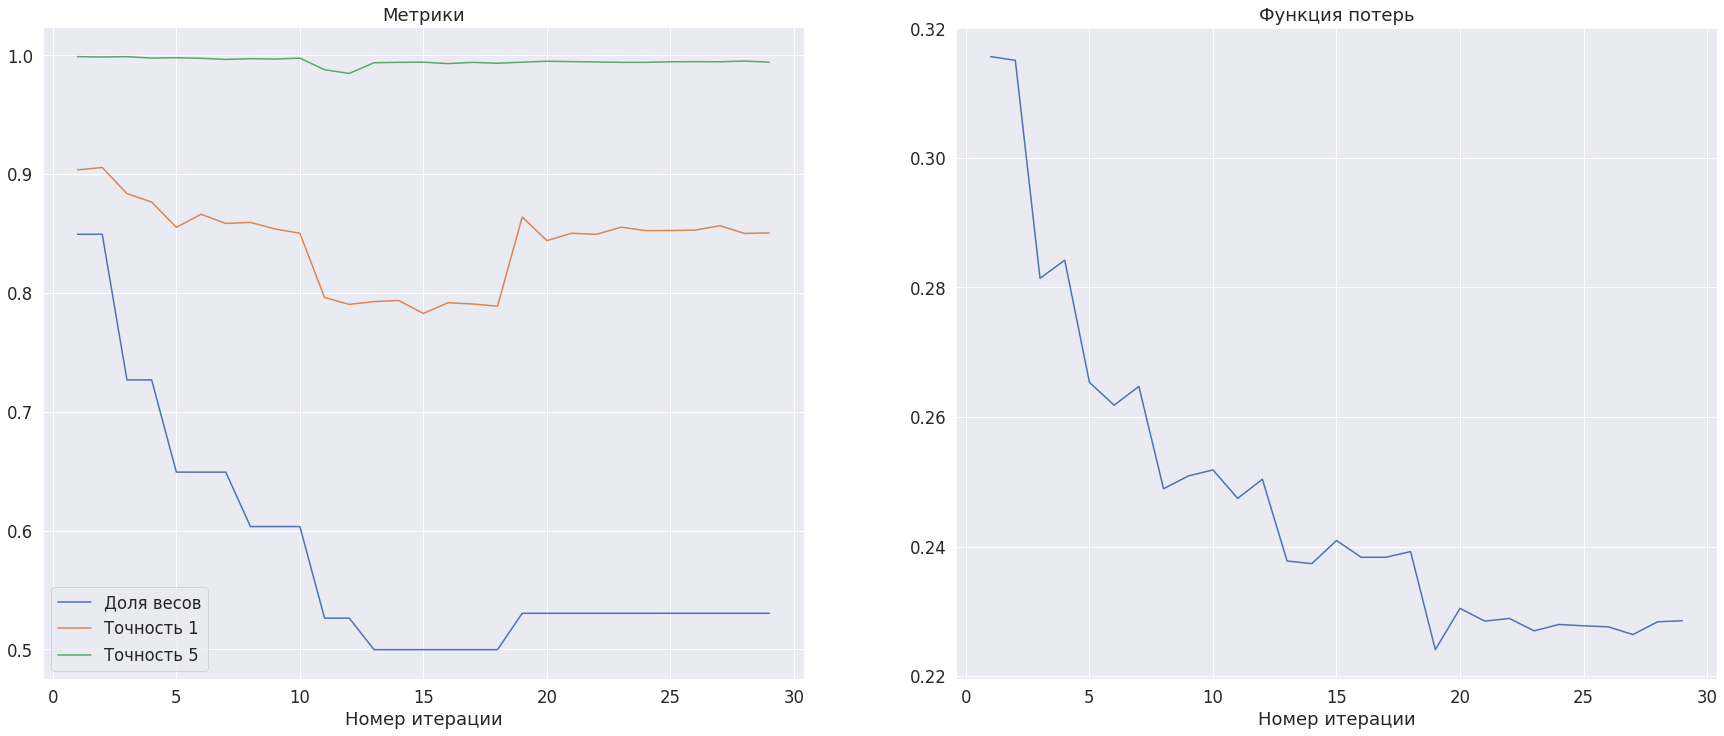

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
brepresentation = ModelPruningEncoder(dnn)
mutator = OneWayMutator(mutation_prob = 0.15)
selector = FitnessSelector()
crossover = LossCrossover()

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

dnn_pruned1 = mtl.prune()

#### Fixed sparsity

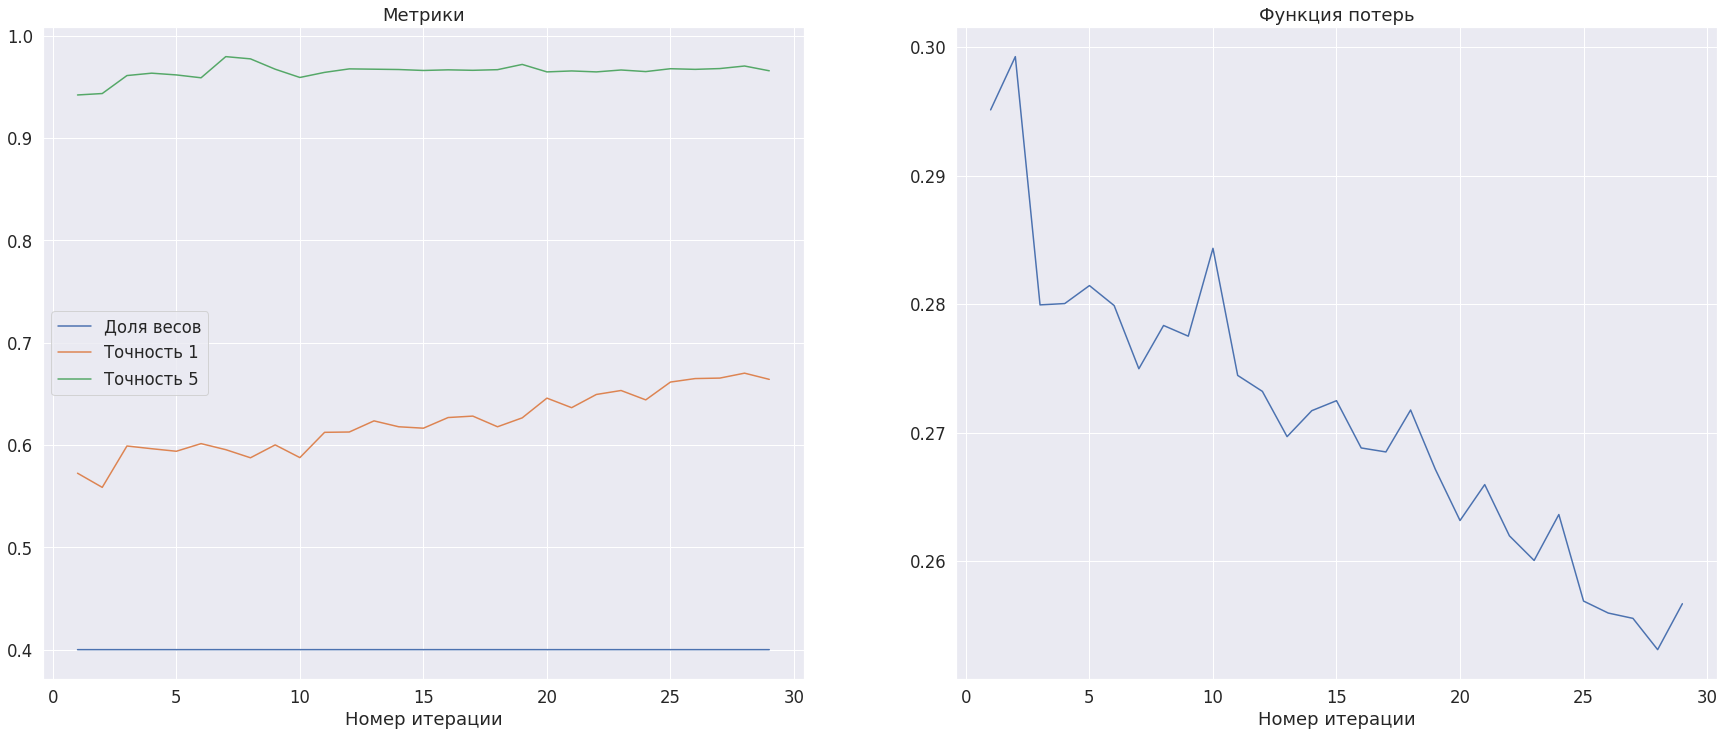

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = ModelPruningEncoder(dnn)
mutator = FixedSparsityMutator()

l1, l2, l3 = 1, 1, 1
def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    top1_errors = 1 - model_acc1
    top5_errors = 1 - model_acc5
    return (l1*weight_ratio + l2*top1_errors + l3*top5_errors) / (l1 + l2 + l3)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, train_loader, max_iter = 200)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

dnn_pruned3 = mtl.prune()

#### Fixed accuracy

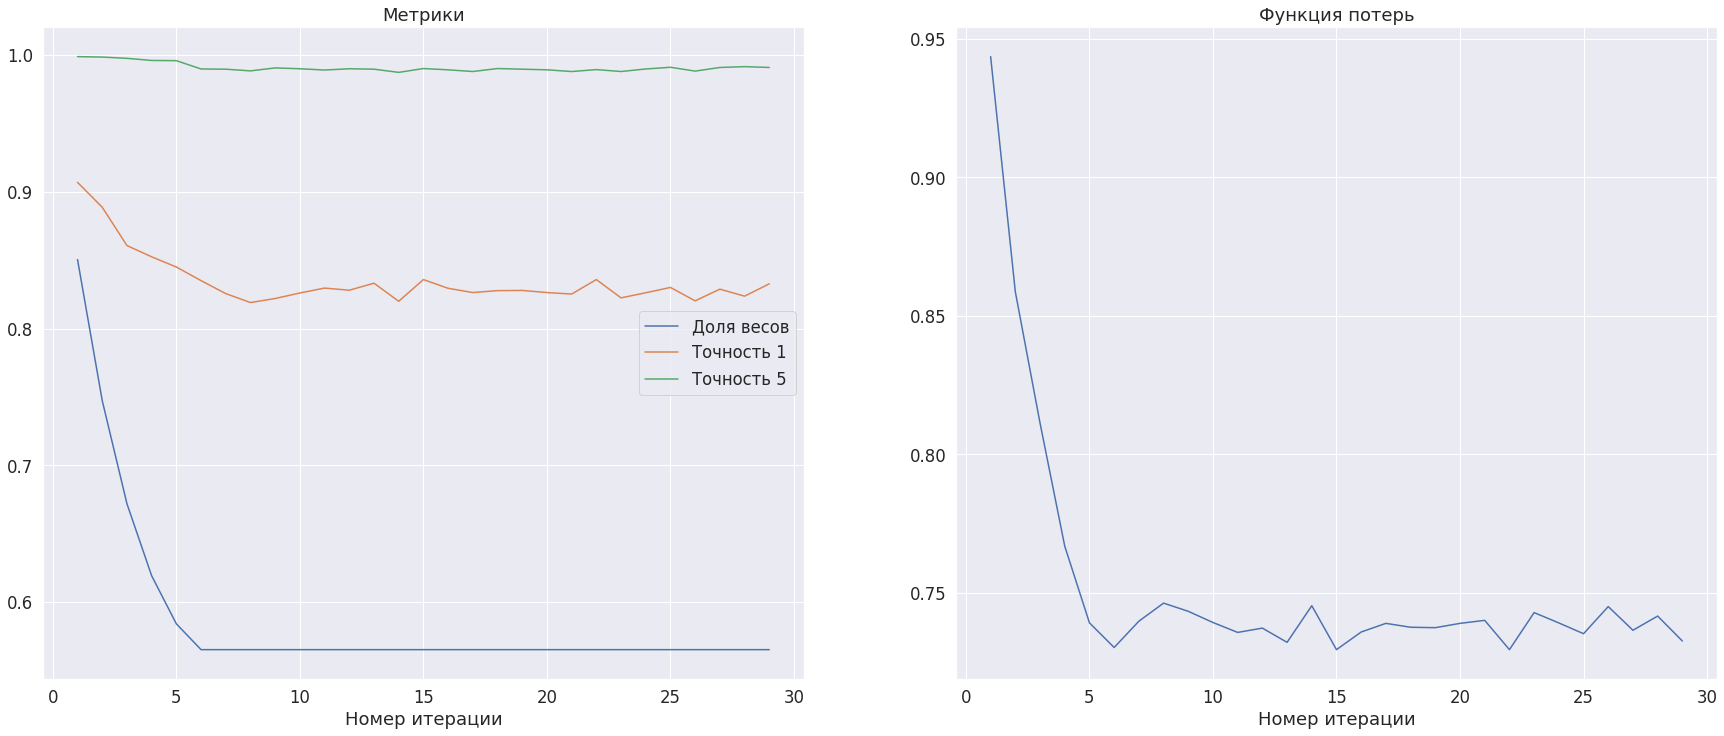

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = ModelPruningEncoder(dnn)
mutator = RandomMutator(mutation_prob = 0.15)

def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    if model_acc1 < 0.8:
      return 1e10
    return torch.as_tensor(weight_ratio + (1 - model_acc1))

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, train_loader, max_iter = 200)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

dnn_pruned1 = mtl.prune()

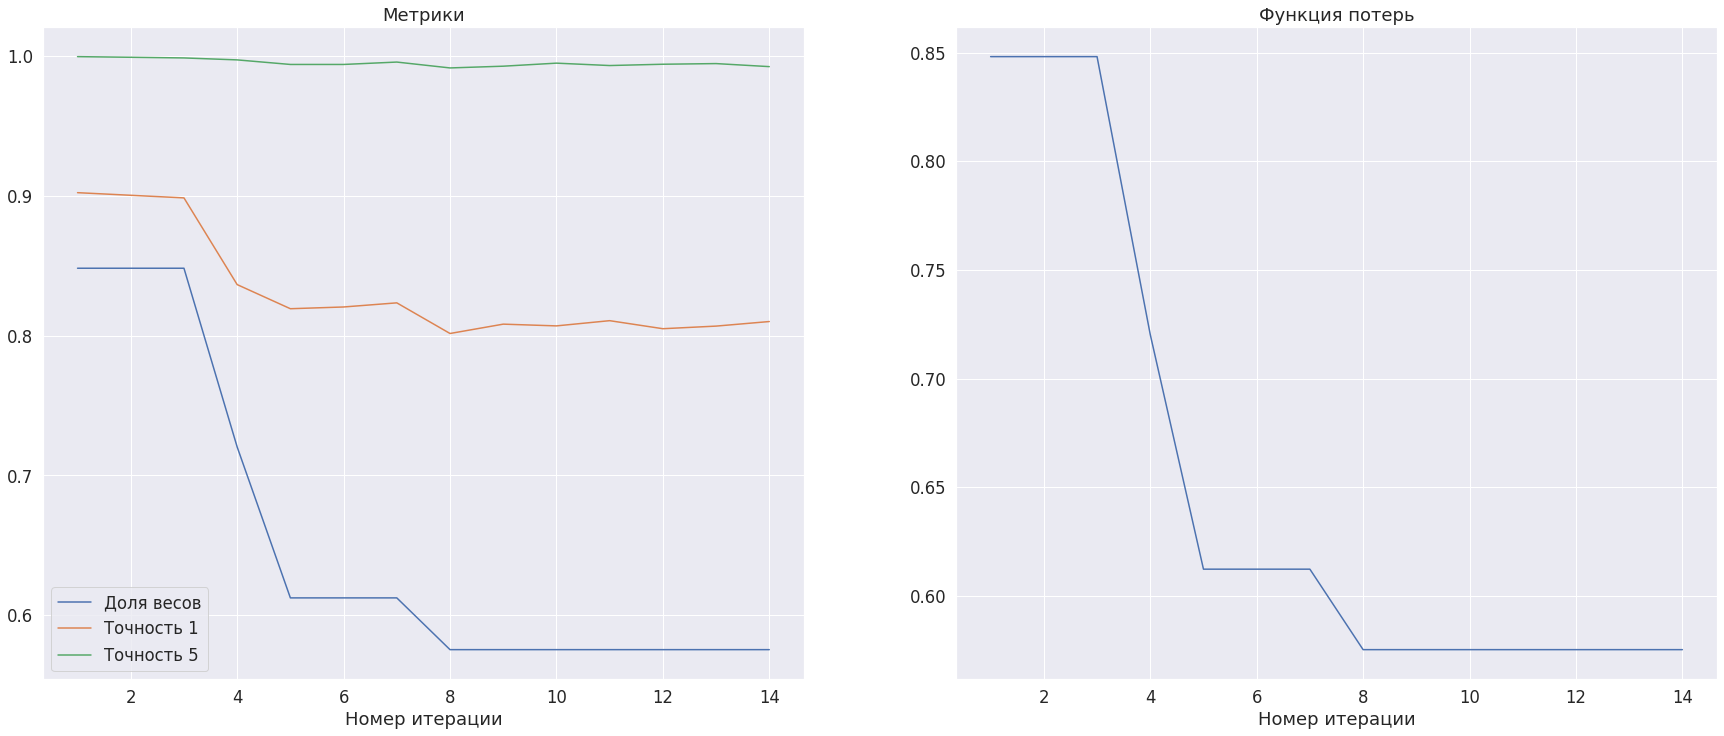

  0%|          | 0/30 [00:00<?, ?it/s]

AttributeError: ignored

In [16]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = ModelPruningEncoder(dnn)
mutator = OneWayMutator(mutation_prob = 0.15)

def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    if model_acc1 < 0.8:
      return 1e10
    return torch.as_tensor(weight_ratio)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, train_loader, max_iter = 200)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

dnn_pruned1 = mtl.prune()

#### Threshold pruning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/10 [00:00<?, ?it/s]

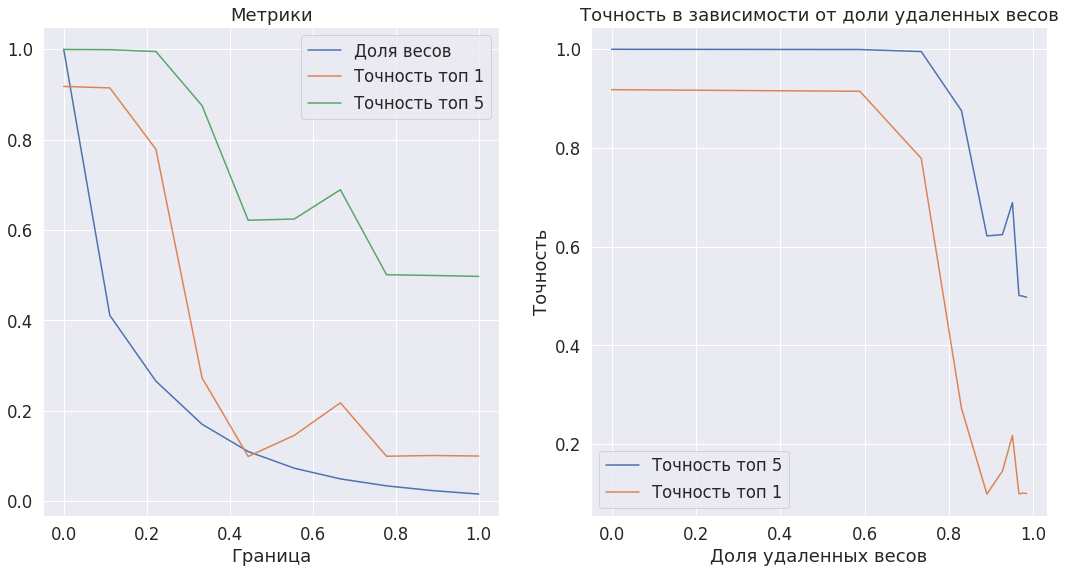

In [15]:
%load_ext autoreload
%autoreload 2
from utils import plot_threshold_pruning
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
plot_threshold_pruning(dnn, train_loader, np.linspace(0, 1, 10))

# CNN

## Training

In [28]:
from torch import nn

out_size = len(classes)
in_size = 28 * 28

cnn = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.25),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.25),
    nn.Conv2d(64, 64, 3),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(576, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).cuda()

Epoch 50 of 50
  training loss (in-iteration): 	0.001271
  validation loss (in-iteration): 	0.001763
  training accuracy: 			93.73 %
  validation accuracy: 			91.08 %


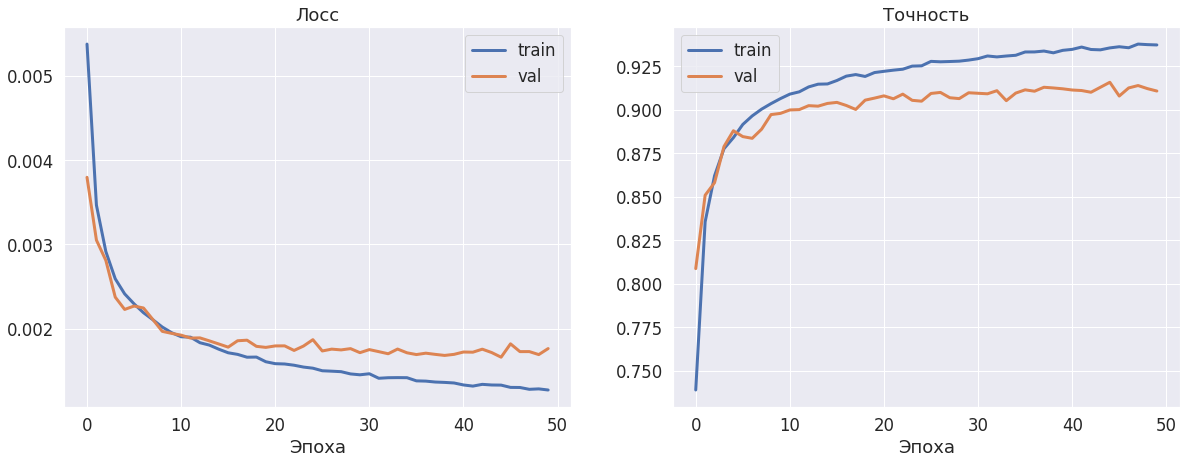

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), weight_decay = 0)
device = torch.device('cuda')

cnn, history = train(
    cnn, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50
)

In [33]:
torch.save(cnn.state_dict(), 'models/mnist_cnn.pt')

In [ ]:
cnn.load_state_dict(torch.load('models/mnist_cnn.pt'))
cnn.eval()

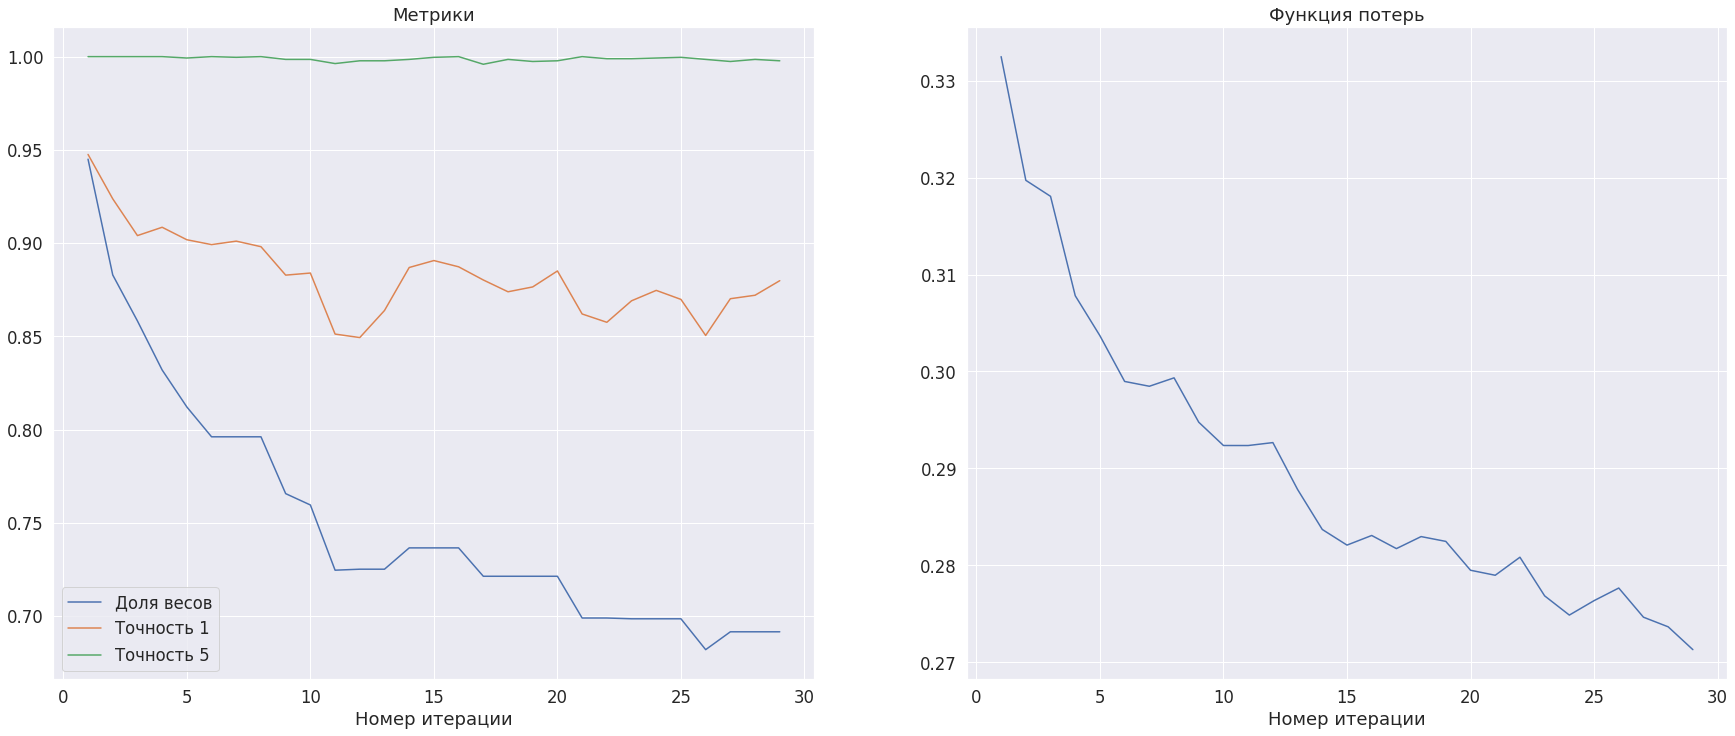

  0%|          | 0/30 [00:00<?, ?it/s]

In [40]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = CNNMaskPrune(cnn)
mutator = ConvGeneMutator(representation.fc_length, representation.conv_length,
                          0.15, 0.01)

l1, l2, l3 = 1, 1, 1
def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    top1_errors = 1 - model_acc1
    top5_errors = 1 - model_acc5
    return (l1*weight_ratio + l2*top1_errors + l3*top5_errors) / (l1 + l2 + l3)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, train_loader, max_iter = 20)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

сnn_pruned1 = mtl.prune()

In [56]:
get_metrics(сnn_pruned1, test_loader, max_iter = 20)

(0.6879204511642456, tensor(0.8225), tensor(0.9963))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/10 [00:00<?, ?it/s]

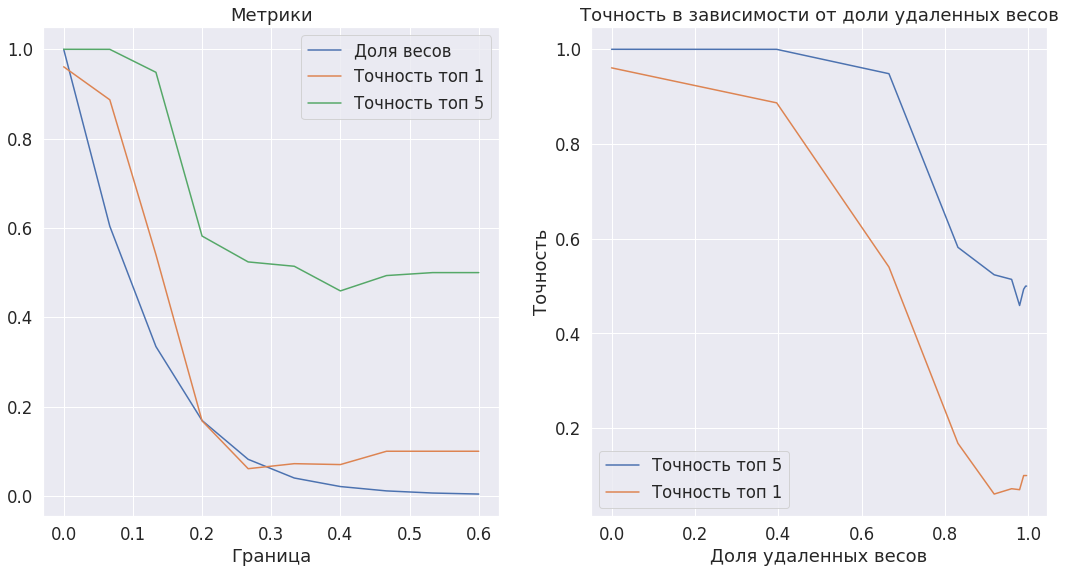

In [59]:
%load_ext autoreload
%autoreload 2
from utils import plot_threshold_pruning
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
plot_threshold_pruning(cnn, train_loader, np.linspace(0, 0.6, 10))

In [57]:
from utils import threshold_prune

pruned = threshold_prune(cnn, gamma = 0.05)
get_metrics(pruned, test_loader, max_iter = 20)

(0.6870817542076111, tensor(0.9014), tensor(0.9974))